In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
%matplotlib inline

In [ ]:
# load data
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
print(f"Training data size is {train_X.shape}\nTesting data size is {test_X.shape}")

Training data size is (60000, 28, 28)
Testing data size is (10000, 28, 28)


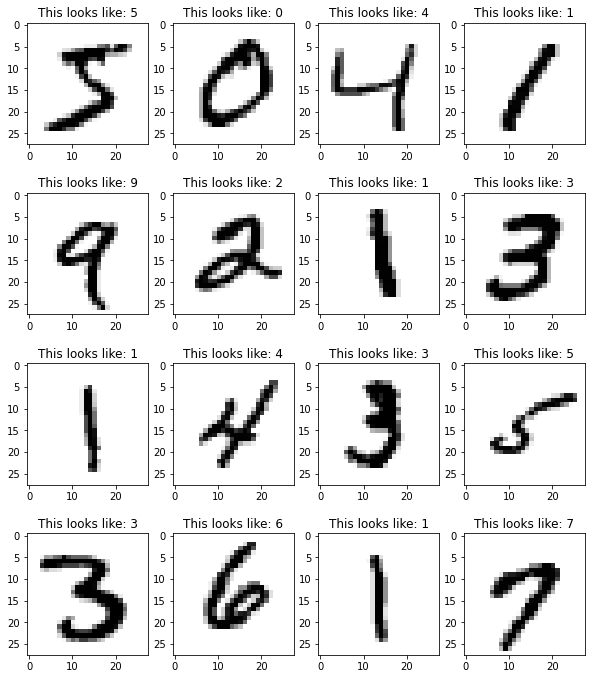

In [ ]:
#trying to see some of the data samples
fig, axis = plt.subplots(4, 4, figsize=(10, 12))
for i, ax in enumerate(axis.flat):
    digit =train_Y[i].argmax()
    ax.set(title = f"This looks like: {train_Y[i]}");
    ax.imshow(train_X[i], cmap='binary')

In [ ]:
train_X = train_X.reshape((train_X.shape[0], 28, 28, 1)).astype('float32')
test_X = test_X.reshape((test_X.shape[0], 28, 28, 1)).astype('float32')
# one hot encode target values
train_Y = to_categorical(train_Y)
test_Y = to_categorical(test_Y)
train_X = train_X / 255.0
test_X = test_X/ 255.0

In [ ]:
print(f"Label size {test_Y.shape}")

Label size (10000, 10)


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

train_gen = datagen.flow(train_X, train_Y, batch_size=128)
test_gen = datagen.flow(test_X, test_Y, batch_size=128)

In [ ]:
epochs = 50
batch_size = 250
train_steps = train_X.shape[0] // batch_size
valid_steps = test_Y.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_loss", # metrics to monitor
        patience=5, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, #
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
history = model.fit_generator(train_gen,
                              epochs = epochs,
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps,
                              callbacks=[es, rp])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
240/240 [==============================] - 55s 222ms/step - loss: 0.3674 - accuracy: 0.8846 - val_loss: 0.5293 - val_accuracy: 0.8314 - lr: 0.0100
Epoch 2/50
240/240 [==============================] - 43s 179ms/step - loss: 0.1187 - accuracy: 0.9642 - val_loss: 0.1054 - val_accuracy: 0.9684 - lr: 0.0100
Epoch 3/50
240/240 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9733
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
240/240 [==============================] - 45s 185ms/step - loss: 0.0903 - accuracy: 0.9733 - val_loss: 0.0990 - val_accuracy: 0.9697 - lr: 0.0100
Epoch 4/50
240/240 [==============================] - 43s 178ms/step - loss: 0.0720 - accuracy: 0.9774 - val_loss: 0.0600 - val_accuracy: 0.9812 - lr: 0.0020
Epoch 5/50
240/240 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9798
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
240/240 [==========================

In [ ]:
model.save('final_model.h5')

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='CNN_model_arch.png', show_shapes=True, show_layer_names=True)

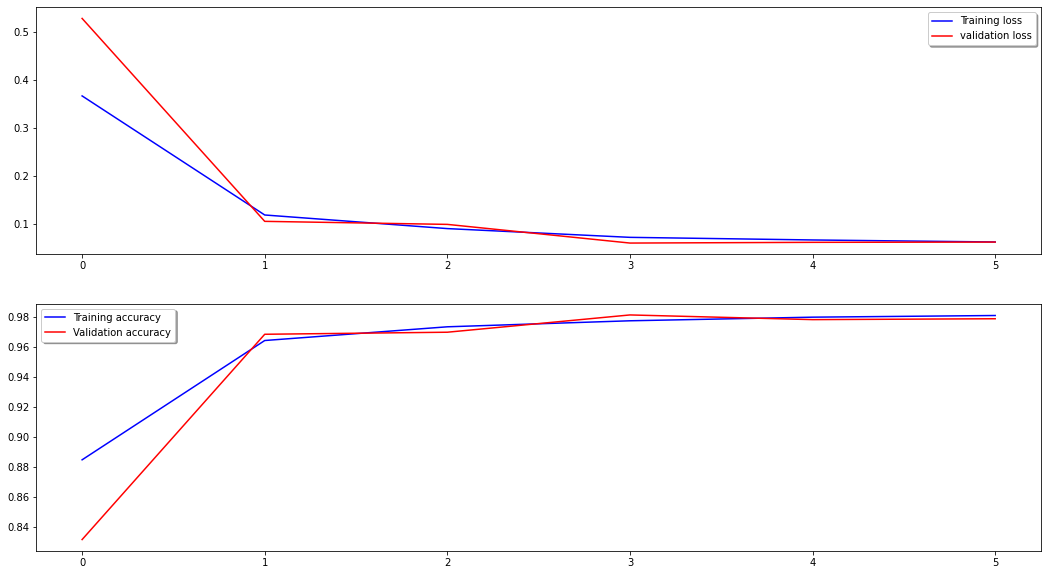

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(test_X) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(test_Y, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [ ]:
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

# load an image and predict the class
def run_example():
	# load the image
	img = load_image('sample_image.png')
	# load model
	model = load_model('final_model.h5')
	# predict the class
	predict_value = model.predict(img)
	digit = argmax(predict_value)
	print("The predicted digit is: ",digit)

# entry point, run the example
run_example()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted digit is:  7


(1, 13, 13, 32)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(1, 13, 13, 32)
(1, 11, 11, 64)
(1, 9, 9, 64)
(1, 4, 4, 64)
(1, 4, 4, 64)
(1, 1024)
(1, 100)
(1, 10)


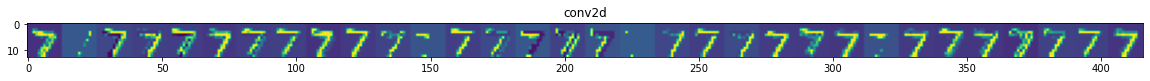

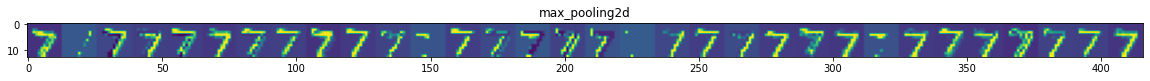

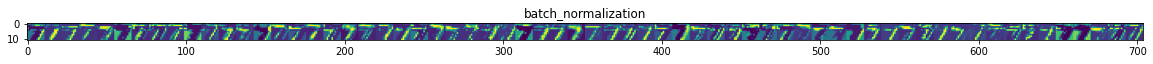

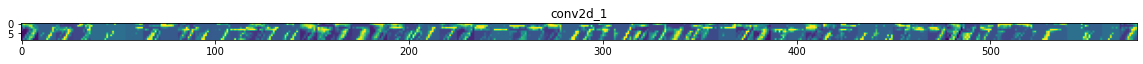

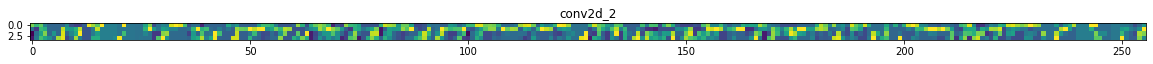

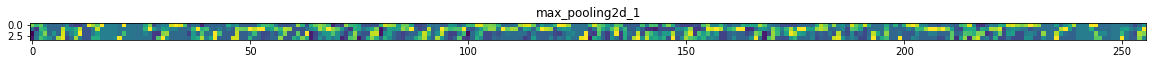

In [ ]:
#filters visualization

img_path='sample_image.png' #dog
# Define a new Model, Input= image
# Output= intermediate representations for all layers in the
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path,grayscale=True, target_size=(28, 28))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:

    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )